In [38]:
import pandas as pd
import nltk
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch
import numpy as np
import hf_xet

import torch
import torch.nn as nn
from scipy.special import softmax

In [39]:
with open('debate_transcripts_cleaned.csv', 'r') as f:
    df_transcripts = pd.read_csv(f)

## Vader Analysis

In [40]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def text_preprocess(text):
    # Tokenize text
    wtokens = word_tokenize(text)

    # Filtering tokens
    t_filtered = [t.lower() for t in wtokens if t.lower() not in stop_words and t.isalpha()]

    # Lemmatization
    t_lemmatized = [lem.lemmatize(t) for t in t_filtered]

    return " ".join(t_lemmatized)

""" # Apply preprocessing to the 'dialogue' column
df_cleaned_text = df_transcripts.copy()
df_cleaned_text["cleaned_text"] = df_transcripts['dialogue'].apply(text_preprocess)

# Display the first 15 entries of original and cleaned columns
df_cleaned_text[['dialogue', 'cleaned_text']].head(15) """

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


' # Apply preprocessing to the \'dialogue\' column\ndf_cleaned_text = df_transcripts.copy()\ndf_cleaned_text["cleaned_text"] = df_transcripts[\'dialogue\'].apply(text_preprocess)\n\n# Display the first 15 entries of original and cleaned columns\ndf_cleaned_text[[\'dialogue\', \'cleaned_text\']].head(15) '

In [41]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [42]:
%%time
def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores

def add_vader_sentiment(df, text_column='dialogue'):
    
    df['vader_full']= df[text_column].apply(analyze_vader)
    df['vader_sentiment'] = df['vader_full'].apply(lambda x: x['compound'])
    df['vader_label']= df['vader_sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
    return df

add_vader_sentiment(df_transcripts, 'dialogue')

CPU times: user 3.01 s, sys: 134 ms, total: 3.14 s
Wall time: 3.22 s


,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,"{'neg': 0.074, 'neu': 0.758, 'pos': 0.169, 'co...",0.9993,positive
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,"{'neg': 0.037, 'neu': 0.834, 'pos': 0.129, 'co...",0.9992,positive
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,"{'neg': 0.0, 'neu': 0.961, 'pos': 0.039, 'comp...",0.3612,positive
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,"{'neg': 0.05, 'neu': 0.95, 'pos': 0.0, 'compou...",-0.2732,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9928,2024_Vance_Walz_VP,2024-10-01,2024,Walz,"Well, thank you, Senator Vance. Thank you to C...",True,Democratic,False,True,False,"{'neg': 0.038, 'neu': 0.756, 'pos': 0.206, 'co...",0.9972,positive
9929,2024_Vance_Walz_VP,2024-10-01,2024,Brennan,"Governor Walz. Thank you. Senator Vance, your ...",False,NaN,False,True,False,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.3612,positive
9930,2024_Vance_Walz_VP,2024-10-01,2024,Vance,"Well, I want to thank Governor Walz, you folks...",True,Republican,True,True,False,"{'neg': 0.033, 'neu': 0.801, 'pos': 0.167, 'co...",0.9960,positive
9931,2024_Vance_Walz_VP,2024-10-01,2024,Brennan,"Senator Vance, thank you. And thank you both f...",False,NaN,False,True,False,"{'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'comp...",0.6124,positive


## BERT

In [ ]:
# Load model and tokenizer
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # set to evaluation mode

# Softmax helper
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def vader_like_scaled(x, alpha=15):
    return x / np.sqrt(x**2 + alpha)

def stretch_to_unit(x, max_scaled_val):
    if max_scaled_val == 0:
        return 0.0
    return x / max_scaled_val

# Sentiment analysis function, returns raw polarity (for dynamic scaling later)
def analyze_full_sentiment(text):
    try:
        encoded_input = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            output = model(**encoded_input)
        scores = output[0][0].numpy()
        scores = np.round(softmax(scores), 4)
        score_dict = {k: float(v) for k, v in zip(["neg", "neu", "pos"], scores)}
        
        # Polarity calculation
        weights = np.array([-1, 0, 1])
        polarity_raw = np.sum(weights * scores)
        polarity_vader_scaled = vader_like_scaled(polarity_raw)

        return pd.Series([score_dict, polarity_raw, polarity_vader_scaled])
    except:
        return pd.Series([{"neg": 0.0, "neu": 1.0, "pos": 0.0}, 0.0, 0.0])

# Apply to DataFrame with dynamic scaling
def add_bert_sentiment(df, text_column="dialogue", alpha=15):
    # First pass to get raw polarity scores
    df[['bert_full', 'bert_raw', 'bert_vader']] = df[text_column].apply(analyze_full_sentiment)

    # Compute max abs polarity to calibrate scaling
    max_val = df['bert_vader'].abs().max()

    # Apply dynamic scaling
    df['bert_sentiment'] = df['bert_vader'].apply(lambda x: stretch_to_unit(x, max_val))

    def label_from_polarity(p):
        if p <= -0.05:
            return "Negative"
        elif p >= 0.05:
            return "Positive"
        else:
            return "Neutral"
    
    df['bert_label'] = df['bert_sentiment'].apply(label_from_polarity)
    df.drop(columns=['bert_raw', 'bert_vader'], inplace=True)
    return df

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest/resolve/refs%2Fpr%2F40/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


## Comparison Values

In [24]:
def add_diff_sentiment(df, text_column='dialogue'):
    df = add_vader_sentiment(df, text_column)
    df = add_bert_sentiment(df, text_column)
    df['diff_sentiment'] = df['vader_sentiment'] - df['bert_sentiment']
    return df

## First Test

In [25]:
%%time
df_sentiment = add_diff_sentiment(df_transcripts, text_column='dialogue')
df_sentiment.to_csv('debate_transcripts_sentiment.csv', index=False)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 13min 1s, sys: 5min 48s, total: 18min 49s
Wall time: 15min 24s


In [26]:
df_sentiment.head()

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_sentiment,bert_label,diff_sentiment
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,"{'neg': 0.074, 'neu': 0.758, 'pos': 0.169, 'co...",0.9993,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",0.000000,Neutral,0.999300
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.009800000116229057, 'neu': 0.9333999...",0.049091,Neutral,-0.049091
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,"{'neg': 0.037, 'neu': 0.834, 'pos': 0.129, 'co...",0.9992,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",0.000000,Neutral,0.999200
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,"{'neg': 0.0, 'neu': 0.961, 'pos': 0.039, 'comp...",0.3612,positive,"{'neg': 0.004900000058114529, 'neu': 0.4332000...",0.575895,Positive,-0.214695
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,"{'neg': 0.05, 'neu': 0.95, 'pos': 0.0, 'compou...",-0.2732,negative,"{'neg': 0.6265000104904175, 'neu': 0.359499990...",-0.632040,Negative,0.358840


In [27]:
df_transcripts.describe(include='all')

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_sentiment,bert_label,diff_sentiment
count,9933,9933,9933.000000,9933,9933,9933,5651,9933,9933,9933,9933,9933.000000,9933,9933,9933.000000,9933,9933.000000
unique,48,48,NaN,172,8563,2,3,2,2,2,5341,NaN,3,8441,NaN,3,NaN
top,2020_Biden_Trump_1,2020-09-29,NaN,Trump,(CROSSTALK),True,Republican,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",NaN,positive,"{'neg': 0.03009999915957451, 'neu': 0.84270000...",NaN,Negative,NaN
freq,858,858,NaN,930,163,5651,2990,7187,7334,8332,3466,NaN,4309,163,NaN,4442,NaN
mean,NaN,NaN,2004.906876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149355,NaN,NaN,-0.064066,NaN,0.213421
std,NaN,NaN,14.783792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507132,NaN,NaN,0.447695,NaN,0.542996
min,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.998800,NaN,NaN,-0.966537,NaN,-1.860336
25%,NaN,NaN,1992.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.385148,NaN,-0.108595
50%,NaN,NaN,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.005536,NaN,0.085739
75%,NaN,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.493900,NaN,NaN,0.150730,NaN,0.551796


In [28]:
df_pres_debate = df_transcripts[(~df_transcripts["VP_debate"])&(df_transcripts["is_candidate"])]

In [29]:
df_pres_debate.sort_values(by='diff_sentiment', ascending=False)

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_sentiment,bert_label,diff_sentiment
6723,2016_Clinton Hillary_Trump_1,2016-09-26,2016,Trump,"And she doesnt say that, because shes got no b...",True,Republican,True,False,False,"{'neg': 0.052, 'neu': 0.673, 'pos': 0.275, 'co...",0.9774,positive,"{'neg': 0.847599983215332, 'neu': 0.1362999975...",-0.849201,Negative,1.826601
9305,2020_Biden_Trump_2,2020-10-22,2020,Trump,"They came out and said very strongly, $6,500 w...",True,Republican,False,False,True,"{'neg': 0.039, 'neu': 0.837, 'pos': 0.124, 'co...",0.9578,positive,"{'neg': 0.8098000288009644, 'neu': 0.172600001...",-0.810616,Negative,1.768416
2608,1992_Bush Sr_Clinton Bill_Perot_3,1992-10-19,1992,Clinton Bill,I really cant believe Mr. Bush is still trying...,True,Democratic,True,False,False,"{'neg': 0.062, 'neu': 0.797, 'pos': 0.141, 'co...",0.9631,positive,"{'neg': 0.798799991607666, 'neu': 0.1837999969...",-0.800097,Negative,1.763197
5137,2008_Mccain_Obama_3,2008-10-15,2008,Mccain,"Well, it is a terribly painful situation for A...",True,Republican,False,False,False,"{'neg': 0.034, 'neu': 0.803, 'pos': 0.163, 'co...",0.9868,positive,"{'neg': 0.7753999829292297, 'neu': 0.203199997...",-0.773084,Negative,1.759884
446,1976_Carter_Ford_3,1976-10-22,1976,Ford,I believe that the uh American people have be...,True,Republican,False,False,True,"{'neg': 0.041, 'neu': 0.811, 'pos': 0.148, 'co...",0.9834,positive,"{'neg': 0.7663999795913696, 'neu': 0.218099996...",-0.770021,Negative,1.753421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,2008_Mccain_Obama_3,2008-10-15,2008,Mccain,"Well, let let me say, Bob, thank you. And tha...",True,Republican,False,False,False,"{'neg': 0.118, 'neu': 0.804, 'pos': 0.079, 'co...",-0.9247,negative,"{'neg': 0.027499999850988388, 'neu': 0.1046999...",0.857884,Positive,-1.782584
4385,2008_Mccain_Obama_1,2008-09-26,2008,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,"{'neg': 0.214, 'neu': 0.662, 'pos': 0.125, 'co...",-0.9811,negative,"{'neg': 0.02889999933540821, 'neu': 0.15260000...",0.808258,Positive,-1.789358
4587,2008_Mccain_Obama_1,2008-09-26,2008,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,"{'neg': 0.214, 'neu': 0.662, 'pos': 0.125, 'co...",-0.9811,negative,"{'neg': 0.02889999933540821, 'neu': 0.15260000...",0.808258,Positive,-1.789358
2389,1992_Bush Sr_Clinton Bill_Perot_3,1992-10-19,1992,Clinton Bill,"4th in manufacturing jobs, 4th in the reductio...",True,Democratic,True,False,False,"{'neg': 0.191, 'neu': 0.714, 'pos': 0.095, 'co...",-0.9255,negative,"{'neg': 0.007799999788403511, 'neu': 0.0903000...",0.910007,Positive,-1.835507


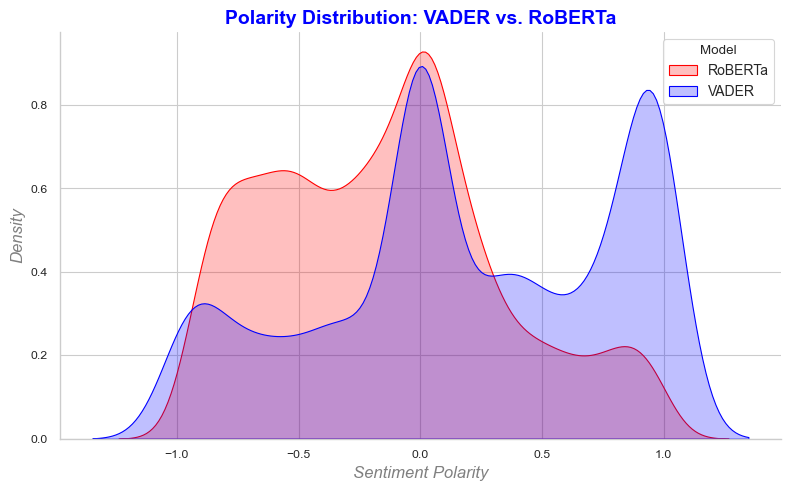

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette="colorblind", context="paper")

# KDE plot for RoBERTa and VADER
sns.kdeplot(df_pres_debate["bert_sentiment"], color="red", fill=True, label="RoBERTa")
sns.kdeplot(df_pres_debate["vader_sentiment"], color="blue", fill=True, label="VADER")

# Plot formatting
plt.xlabel("Sentiment Polarity", fontsize=12, fontstyle="italic", color="gray")
plt.ylabel("Density", fontsize=12, fontstyle="italic", color="gray")
plt.title("Polarity Distribution: VADER vs. RoBERTa", fontsize=14, weight="bold", color="blue")
plt.legend(title="Model", fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


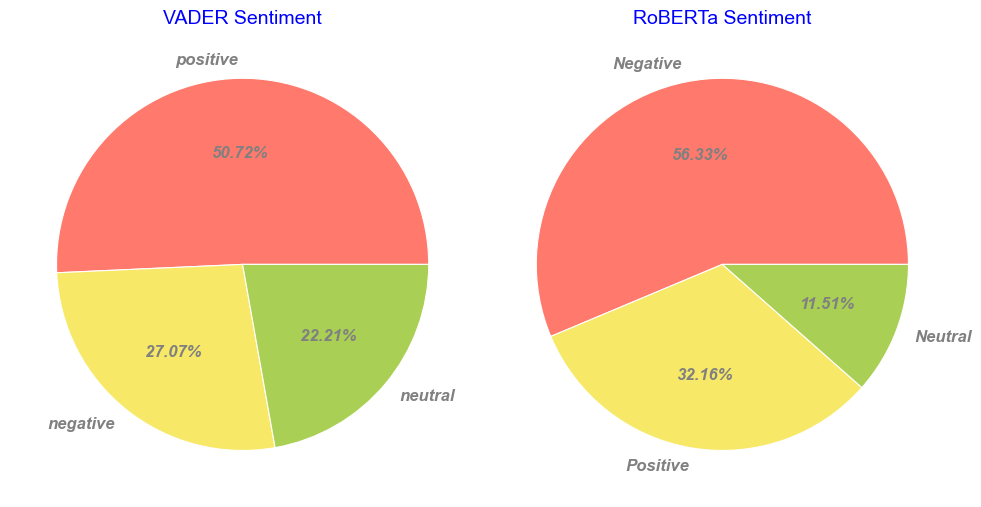

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

colors = ["#ff7a6c", "#F7E967", "#A9CF54"]
textprops = dict(fontsize=12, fontstyle="italic", weight="bold", color="gray")

# VADER pie chart
df_pres_debate["vader_label"].value_counts(normalize=True).plot.pie(
    ax=axes[0], autopct="%.2f%%", colors=colors, textprops=textprops, ylabel=""
)
axes[0].set_title("VADER Sentiment", fontsize=14, color="blue")

# RoBERTa pie chart
df_pres_debate["bert_label"].value_counts(normalize=True).plot.pie(
    ax=axes[1], autopct="%.2f%%", colors=colors, textprops=textprops, ylabel=""
)
axes[1].set_title("RoBERTa Sentiment", fontsize=14, color="blue")

plt.tight_layout()
plt.show()


### Model

/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/2644799410.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text() for label in xticklabels], rotation=90)


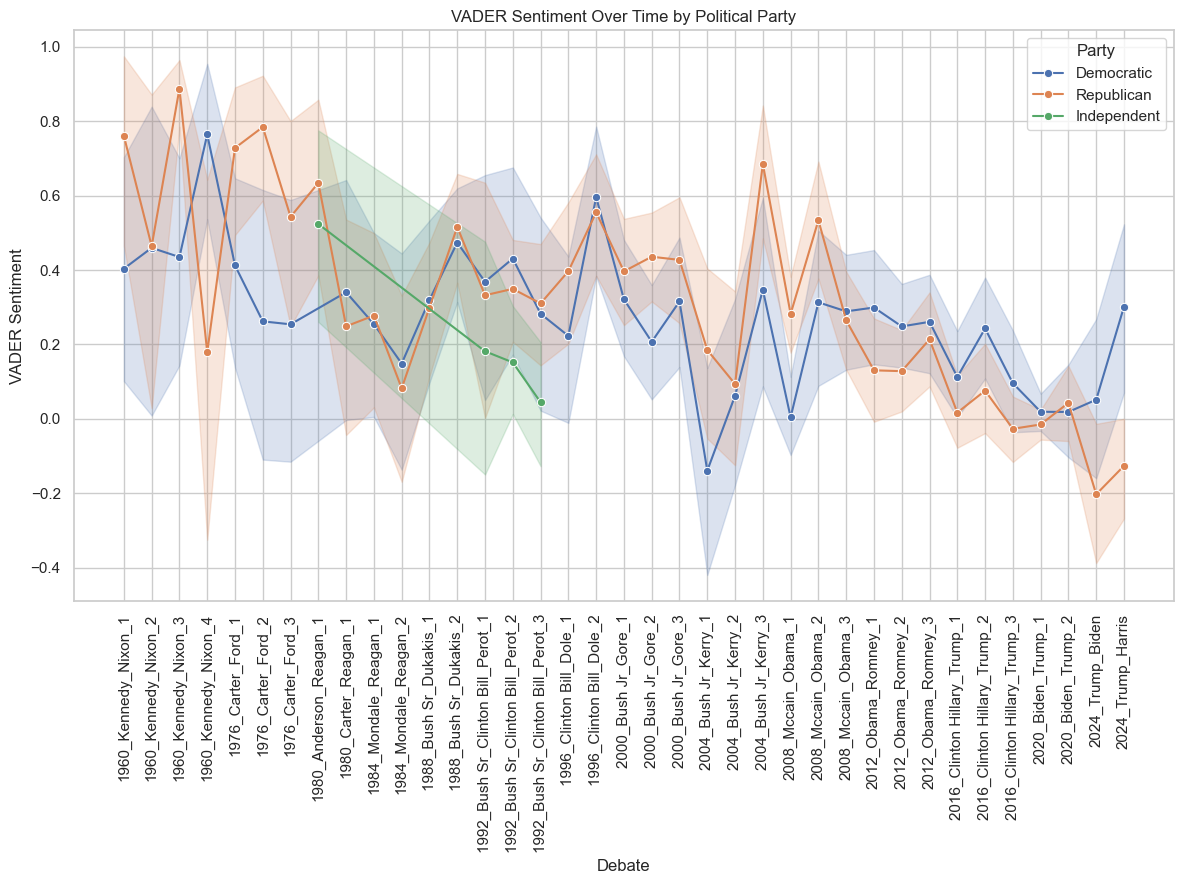

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 9))
ax = sns.lineplot(data=df_pres_debate, x='debate_title', y='vader_sentiment', hue='party', marker='o')

# Set title and labels
plt.title('VADER Sentiment Over Time by Political Party')
plt.xlabel('Debate')
plt.ylabel('VADER Sentiment')
plt.legend(title='Party')

# Modify x-axis ticks to show only every 4th label
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticklabels([label.get_text() for label in xticklabels], rotation=90)

plt.tight_layout()
plt.show()

/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/3739708056.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text() for label in xticklabels], rotation=90)


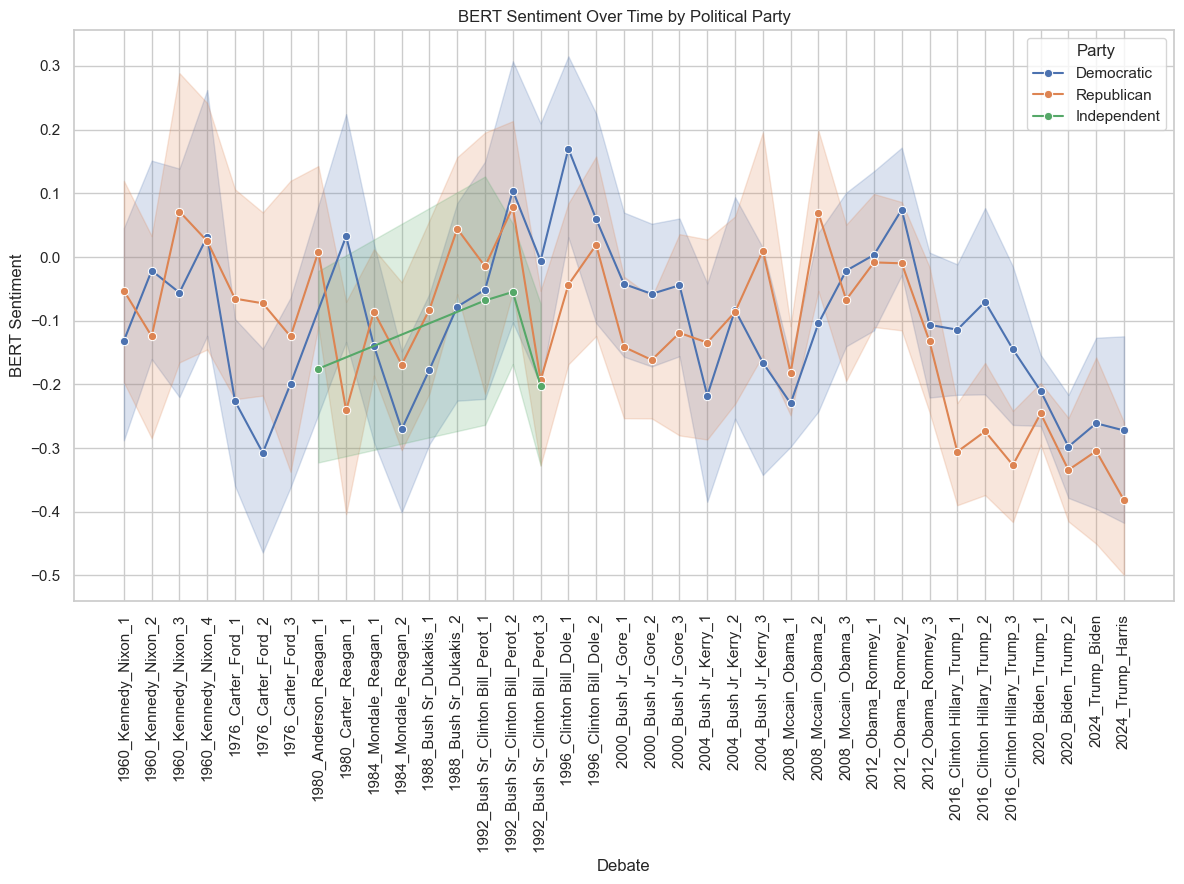

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 9))
ax = sns.lineplot(data=df_pres_debate, x='debate_title', y='bert_sentiment', hue='party', marker='o')

# Set title and labels
plt.title('BERT Sentiment Over Time by Political Party')
plt.xlabel('Debate')
plt.ylabel('BERT Sentiment')
plt.legend(title='Party')

# Modify x-axis ticks to show only every 4th label
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticklabels([label.get_text() for label in xticklabels], rotation=90)


plt.tight_layout()
plt.show()

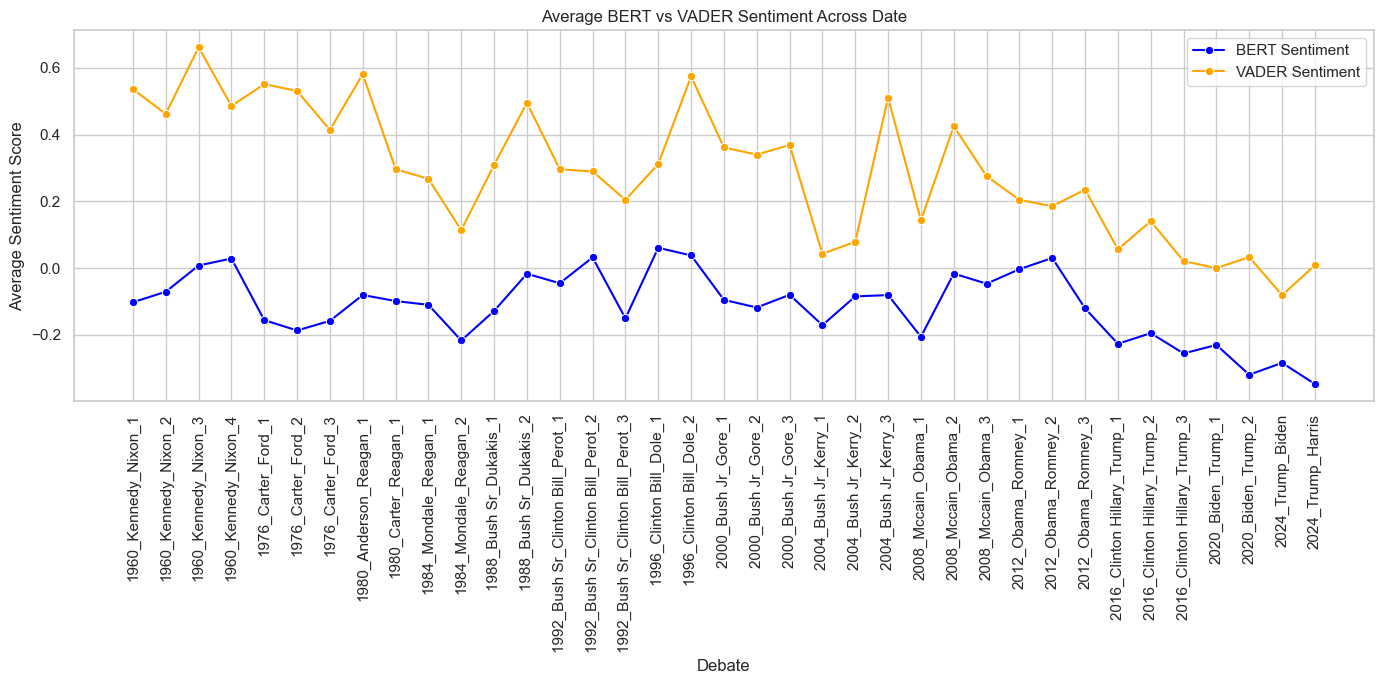

In [34]:
plt.figure(figsize=(14, 7))

# Calculate average sentiment per date
avg_sentiment = df_pres_debate.groupby('debate_title')[['bert_sentiment', 'vader_sentiment']].mean().reset_index()

sns.lineplot(
    data=avg_sentiment,
    x='debate_title',
    y='bert_sentiment',
    label='BERT Sentiment',
    color='blue',
    marker='o'
)
sns.lineplot(
    data=avg_sentiment,
    x='debate_title',
    y='vader_sentiment',
    label='VADER Sentiment',
    color='orange',
    marker='o'
)

plt.title('Average BERT vs VADER Sentiment Across Date')
plt.xlabel('Debate')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

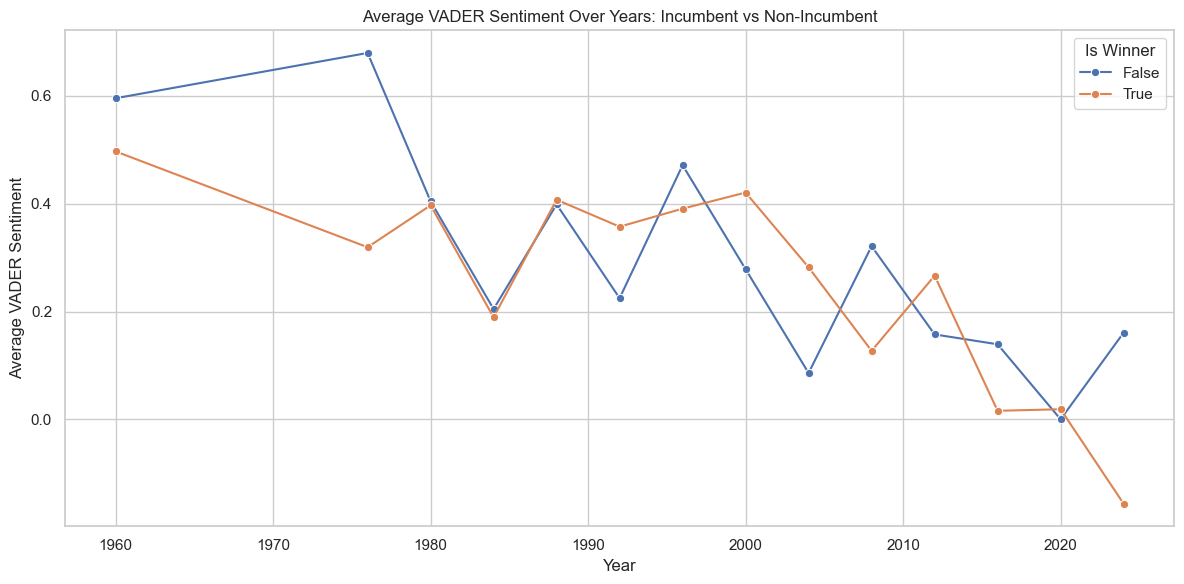

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group by year and incumbent status
avg_sentiment_by_year_incumbent = (
    df_pres_debate.groupby(['year', 'is_winner'])['vader_sentiment']
    .mean()
    .reset_index()
)

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_sentiment_by_year_incumbent,
    x='year',
    y='vader_sentiment',
    hue='is_winner',
    marker='o'
)

# Add labels and title
plt.title('Average VADER Sentiment Over Years: Incumbent vs Non-Incumbent')
plt.xlabel('Year')
plt.ylabel('Average VADER Sentiment')
plt.legend(title='Is Winner')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/2884074730.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_pres_debate, x='year', y='vader_sentiment', hue='is_incumbent', ci=None, marker='o')


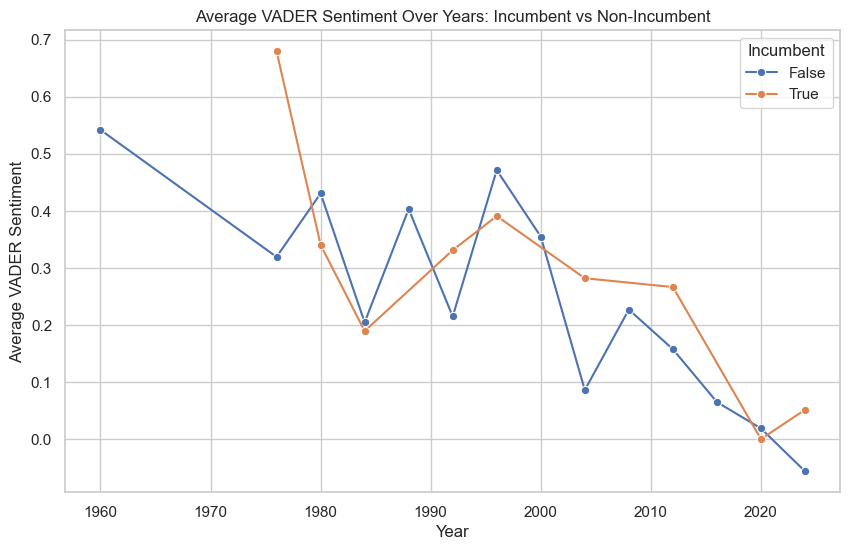

In [57]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pres_debate, x='year', y='vader_sentiment', hue='is_incumbent', ci=None, marker='o')
plt.title('Average VADER Sentiment Over Years: Incumbent vs Non-Incumbent')
plt.xlabel('Year')
plt.ylabel('Average VADER Sentiment')
plt.legend(title='Incumbent')
plt.grid(True)
plt.show()

/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/1429146764.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_pres_debate, x='year', y='bert_sentiment', hue='is_incumbent', ci=None, marker='o')


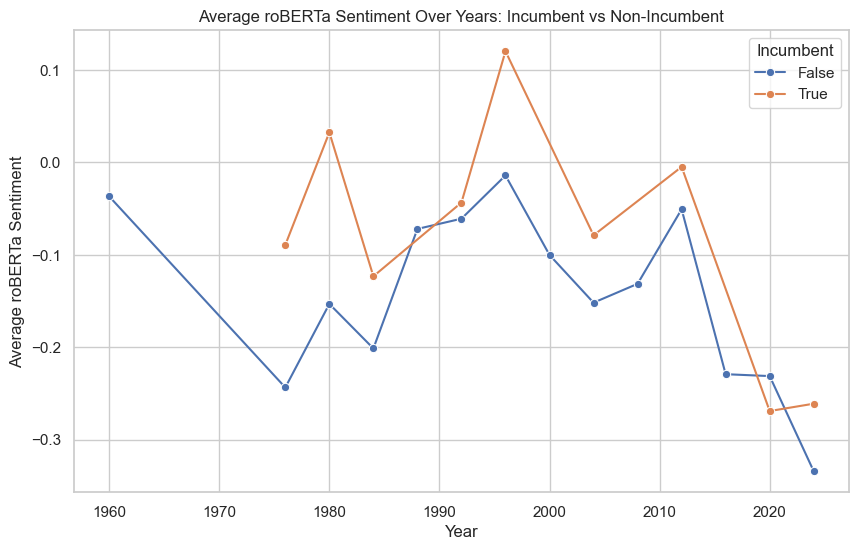

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pres_debate, x='year', y='bert_sentiment', hue='is_incumbent', ci=None, marker='o')
plt.title('Average roBERTa Sentiment Over Years: Incumbent vs Non-Incumbent')
plt.xlabel('Year')
plt.ylabel('Average roBERTa Sentiment')
plt.legend(title='Incumbent')
plt.grid(True)
plt.show()


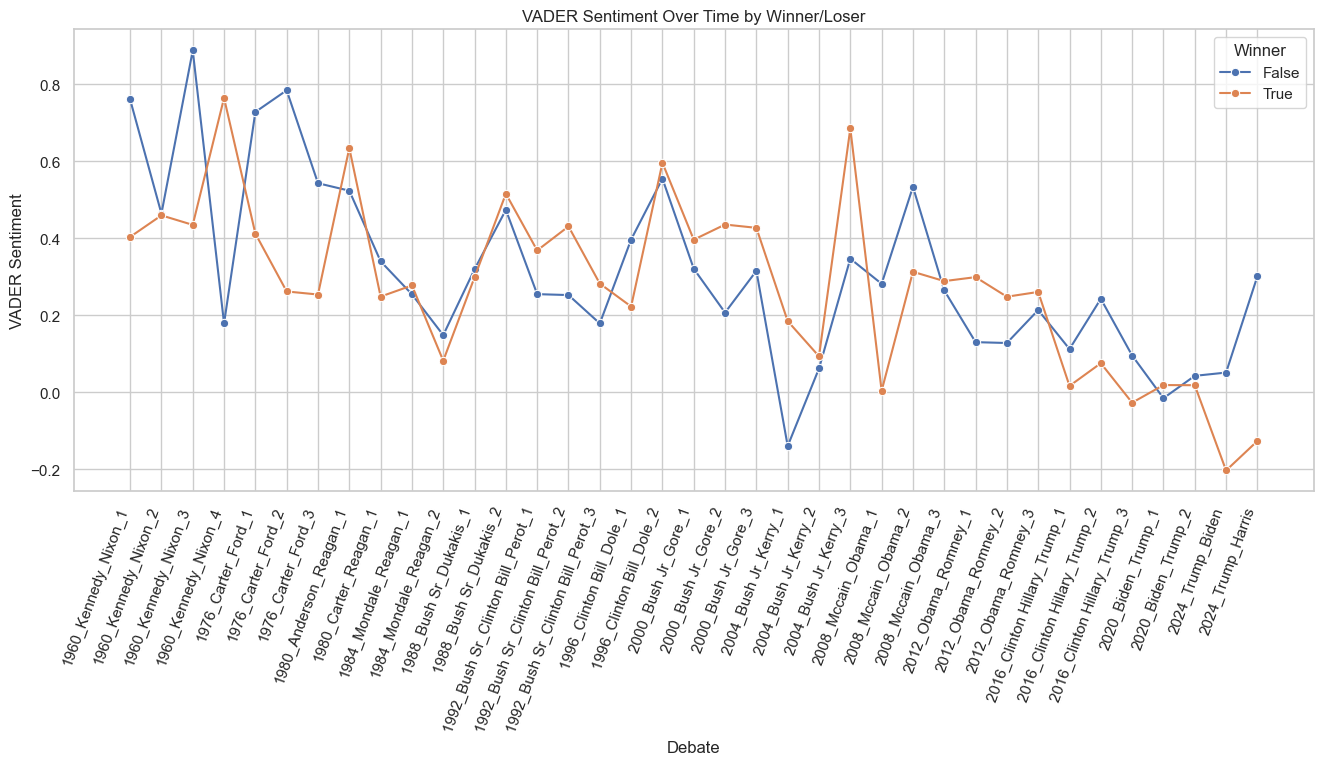

In [55]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_pres_debate, x='debate_title', y='vader_sentiment', hue='is_winner', errorbar=None, marker ='o')
plt.title('VADER Sentiment Over Time by Winner/Loser')
plt.xlabel('Debate')
plt.ylabel('VADER Sentiment')
plt.legend(title='Winner')
plt.xticks(rotation=70, ha='right')
plt.grid(True)
plt.show()

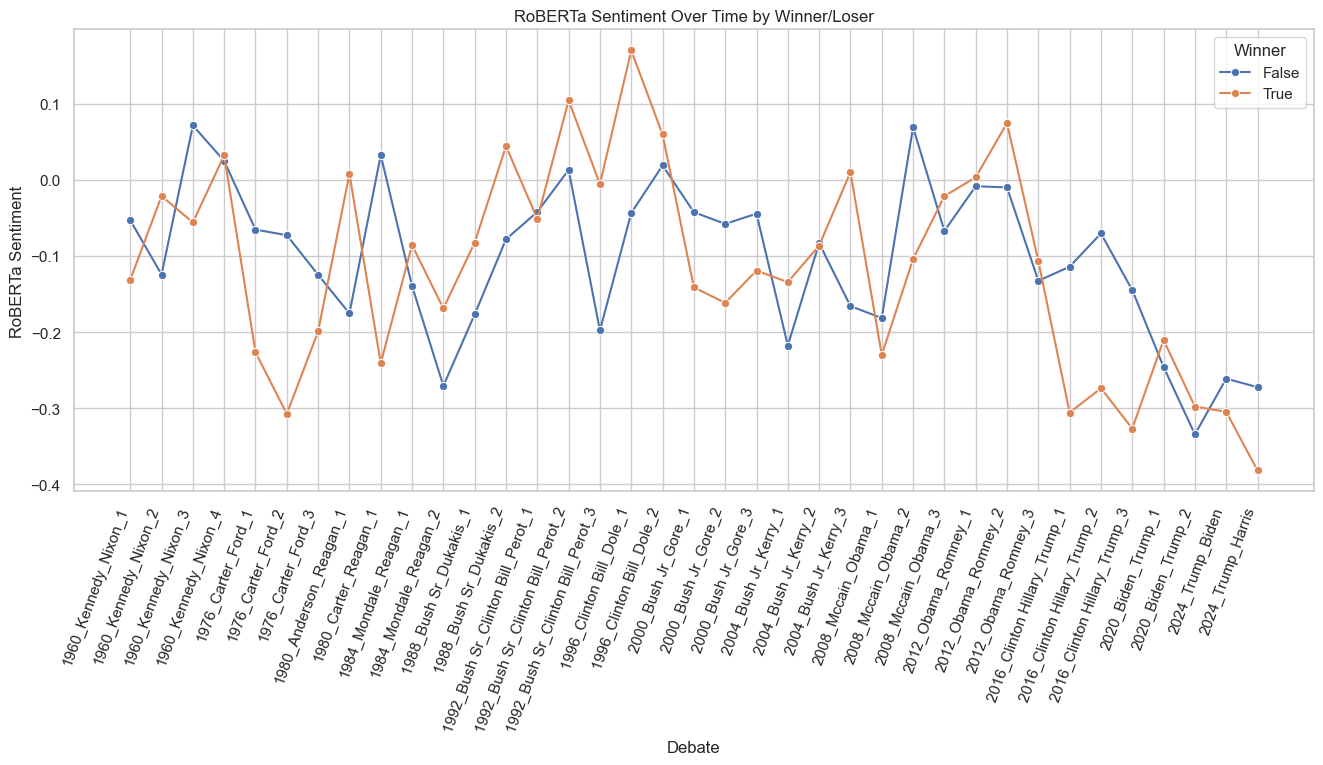

In [56]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_pres_debate, x='debate_title', y='bert_sentiment', hue='is_winner', errorbar=None, marker ='o')
plt.title('RoBERTa Sentiment Over Time by Winner/Loser')
plt.xlabel('Debate')
plt.ylabel('RoBERTa Sentiment')
plt.legend(title='Winner')
plt.xticks(rotation=70, ha='right')
plt.grid(True)
plt.show()

/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/236361314.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


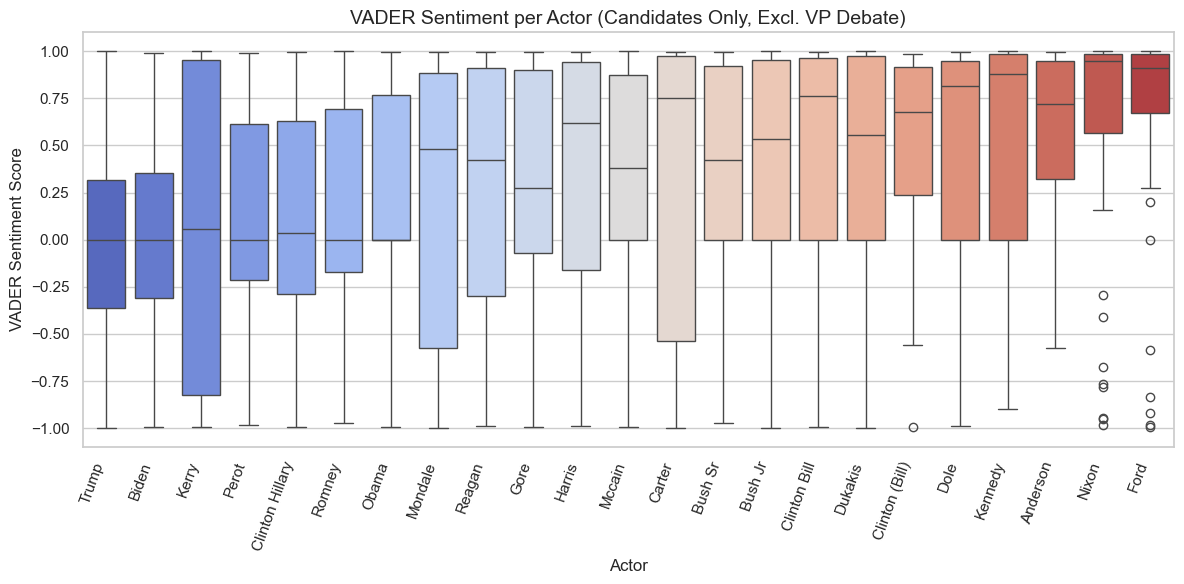

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate mean sentiment per actor for ordering
mean_sentiment = df_pres_debate.groupby('actor')['vader_sentiment'].mean().sort_values()

# Set the order of actors based on mean sentiment
actor_order = mean_sentiment.index

# Set the plot size and style
plt.figure(figsize=(12, 6))

# Create the box plot
sns.boxplot(
    data=df_pres_debate,
    x='actor',
    y='vader_sentiment',
    order=actor_order,
    palette='coolwarm'
)

# Customize the plot
plt.title('VADER Sentiment per Actor (Candidates Only, Excl. VP Debate)', fontsize=14)
plt.xlabel('Actor', fontsize=12)
plt.ylabel('VADER Sentiment Score', fontsize=12)
plt.xticks(rotation=70, ha='right')
plt.tight_layout()

plt.show()


/var/folders/q6/_j2zk51n3hz5tm9sn6q708xr0000gn/T/ipykernel_57113/4201184884.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


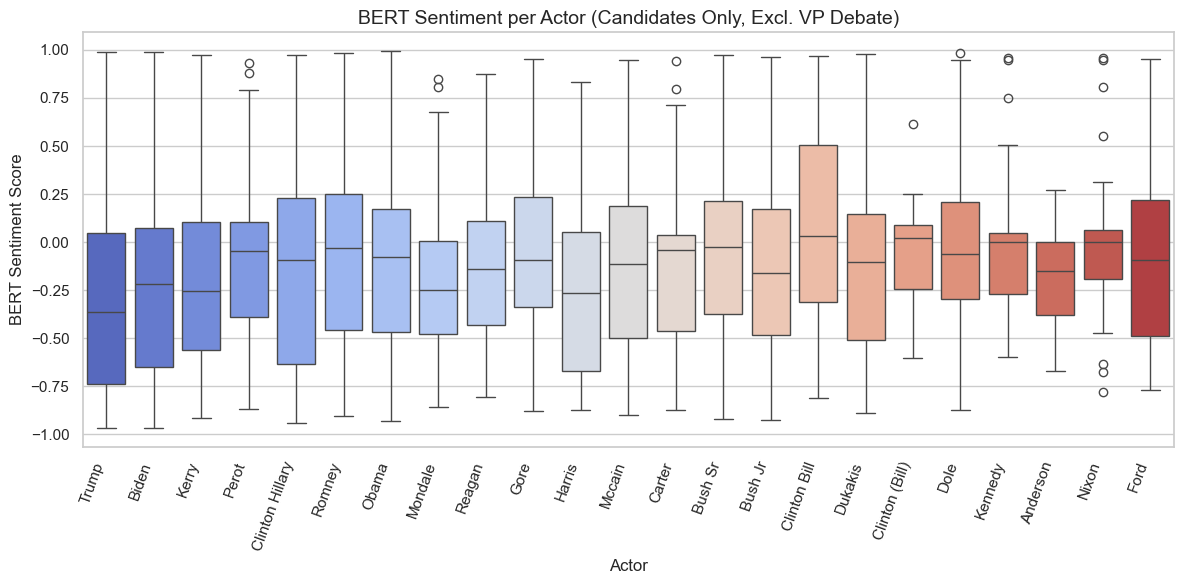

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate mean sentiment per actor for ordering
mean_sentiment = df_pres_debate.groupby('actor')['vader_sentiment'].mean().sort_values()

# Set the order of actors based on mean sentiment
actor_order = mean_sentiment.index

# Set the plot size and style
plt.figure(figsize=(12, 6))

# Create the box plot
sns.boxplot(
    data=df_pres_debate,
    x='actor',
    y='bert_sentiment',
    order=actor_order,
    palette='coolwarm'
)

# Customize the plot
plt.title('BERT Sentiment per Actor (Candidates Only, Excl. VP Debate)', fontsize=14)
plt.xlabel('Actor', fontsize=12)
plt.ylabel('BERT Sentiment Score', fontsize=12)
plt.xticks(rotation=70, ha='right')
plt.tight_layout()

plt.show()
